[View in Colaboratory](https://colab.research.google.com/github/hiro-yoshida/DeepSurv-TF-Mod/blob/master/DeepSurv-TF%20Demo-3.ipynb)

## Environment set up (run only for Colaboratory)

In [ ]:
# Colaboratory
!pip install lifelines
!pip install -r https://raw.githubusercontent.com/Lasagne/Lasagne/master/requirements.txt
!pip install https://github.com/Lasagne/Lasagne/archive/master.zip

In [2]:
%cd
#!rm -rf DeepSurv-TF-Mod
!git clone https://github.com/hiro-yoshida/DeepSurv-TF-Mod.git
%cd DeepSurv-TF-Mod

/root
Cloning into 'DeepSurv-TF-Mod'...
remote: Counting objects: 150, done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 150 (delta 40), reused 134 (delta 31), pack-reused 0
Receiving objects: 100% (150/150), 3.08 MiB | 5.89 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/root/DeepSurv-TF-Mod


## DeepSruv-TF demo for simulated linear and non-linear data

In [2]:
# Set environment variable
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # "0, 1" for multiple GPUs
# impoart tensorflow
import tensorflow as tf
print(tf.__version__)
# Allow growing memmory 
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

1.10.0


### Import DeepSurv packages

In [3]:
import sys
sys.path.append("deepsurv")
import deepsurv_tf
import deepsurv

Using gpu device 0: GeForce GTX 1080 Ti (CNMeM is disabled, cuDNN 6021)
/home/yoshida/anaconda3/envs/deepsurv_all/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


### Import utility packages

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy
import seaborn as sns
import pandas
import h5py as h5
import lasagne

In [5]:
import sys
sys.path.append("deepsurv")
%matplotlib inline

In [6]:
epochs= 3000

def h5_to_deepsurv_ds(file_, type='train'):
    e = file_[type]['e'].value
    t = file_[type]['t'].value
    x = file_[type]['x'].value

    # Return the deep surv dataframe
    return {
        'x': x,
        'e': e,
        't': t
    }

params = deepsurv_tf.Parameters()
params.n_epochs = epochs

### Simulatd linear survival data

In [7]:
dataset = h5.File("data/linear/linear_survival_data.h5", 'r')

train = h5_to_deepsurv_ds(dataset)
valid = h5_to_deepsurv_ds(dataset, 'valid')
test = h5_to_deepsurv_ds(dataset, 'test')

Training done
Best epoch 860
Best loss 3017.3164
INFO:tensorflow:Restoring parameters from out/learned.model


/home/yoshida/anaconda3/envs/deepsurv_all/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


model loaded
test CI: 0.7729419613075383


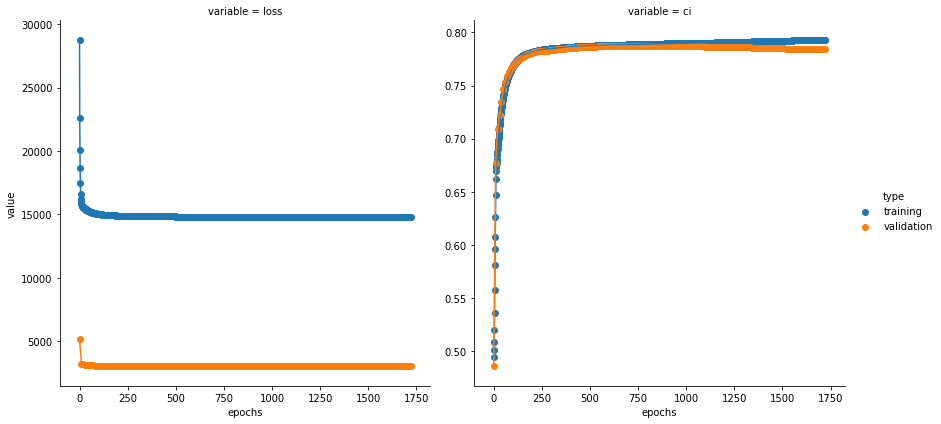

In [8]:
params.n_in = train['x'].shape[1]

ds_tf = deepsurv_tf.DeepSurvTF(params)
stats = ds_tf.train(train, valid)

stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop=True)
stats = pandas.melt(stats, id_vars=["epochs", "type"])

sns.FacetGrid(data=stats, hue="type", col="variable", sharey=False, size=6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

print("test CI: {}".format(ds_tf.get_concordance_index(test['x'], test['e'], test['t'])))

#### Run deepsurv-theanos

test CI: 0.5262681787858572


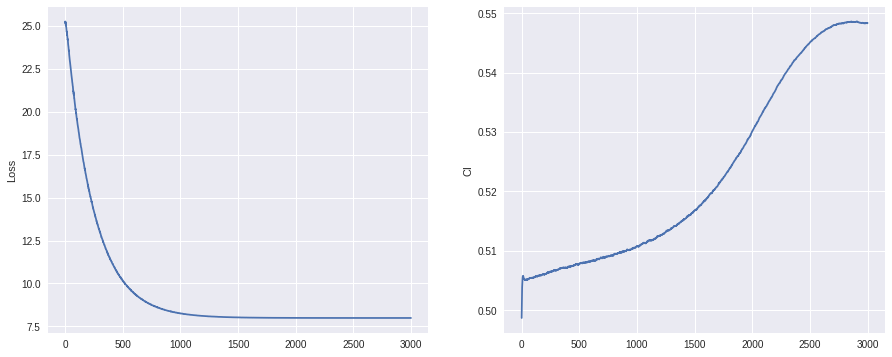

In [ ]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train['x'].shape[1],
    'standardize': True
}

network = deepsurv.DeepSurv(**hyperparams)
update_fn = lasagne.updates.nesterov_momentum

log = network.train(train, valid, n_epochs=epochs, update_fn=update_fn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
ax1.plot(log["train"], label="training loss")
ax1.set_ylabel("Loss")
ax2.set_ylabel("CI")
ax2.plot(log["train_ci"], label="training ci")
print("test CI: {}".format(network.get_concordance_index(test['x'], test['t'], test['e'])))

### Simulated non-linear (Gaussian) survival data

In [ ]:
dataset = h5.File("data/gaussian/gaussian_survival_data.h5", 'r')

train = h5_to_deepsurv_ds(dataset)
valid = h5_to_deepsurv_ds(dataset, 'valid')
test = h5_to_deepsurv_ds(dataset, 'test')

Training done
Best epoch 2990
Best loss 3230.155
INFO:tensorflow:Restoring parameters from out/learned.model
model loaded
test CI: 0.6403789192795197


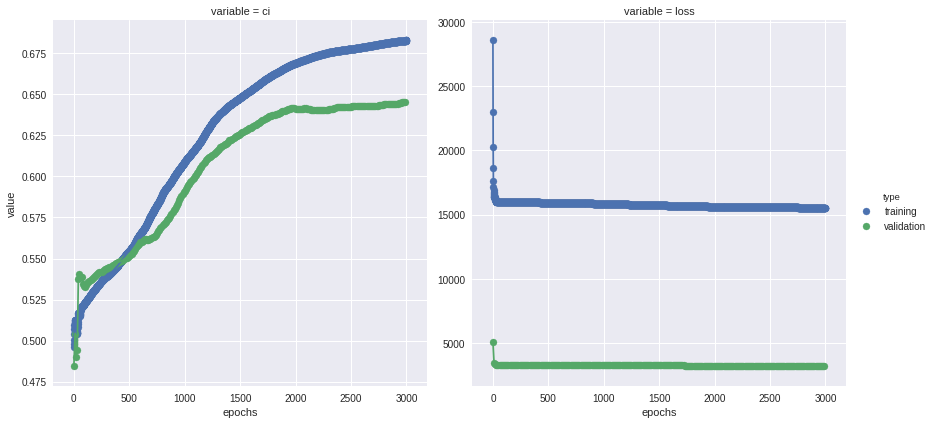

In [ ]:
params.n_in = train['x'].shape[1]

ds_tf = deepsurv_tf.DeepSurvTF(params)
stats = ds_tf.train(train, valid)

stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop=True)
stats = pandas.melt(stats, id_vars=["epochs", "type"])

sns.FacetGrid(data=stats, hue="type", col="variable", sharey=False, size=6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

print("test CI: {}".format(ds_tf.get_concordance_index(test['x'], test['e'], test['t'])))

#### Run deepsurv-theano

test CI: 0.5319533022014676


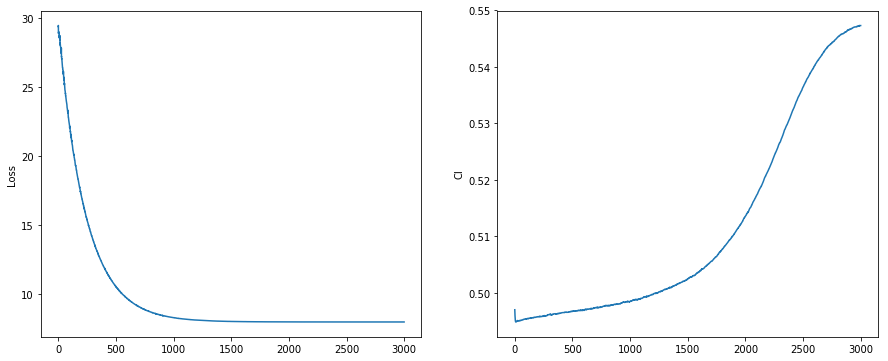

In [ ]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train['x'].shape[1],
    'standardize': True
}

network = deepsurv.DeepSurv(**hyperparams)
update_fn = lasagne.updates.nesterov_momentum

log = network.train(train, valid, n_epochs=epochs, update_fn=update_fn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(log["train"], label="training loss")
ax1.set_ylabel("Loss")
ax2.set_ylabel("CI")
ax2.plot(log["train_ci"], label="training ci")
print("test CI: {}".format(network.get_concordance_index(test['x'], test['t'], test['e'])))